In [1]:
import os
import json
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## import print data

In [2]:
folder: str = 'data/no_clog_data'
minimum_time: float = 30 # minimum time in minutes

files = os.listdir(folder)
useable_files = []
print_temp = []
for file in files:
    if file.endswith('json'):
            with open(os.path.join(folder, file)) as meta:
                metadata = json.load(meta)
                temp = metadata['setup']['print_temperature']
                if temp < 180:
                     continue
                print_temp.append(temp)
            
            # only use complete prints
            if metadata['setup']['print_end_status'] == 'complete':
                base = os.path.splitext(os.path.basename(file))[0]
                useable_files.append(os.path.join(folder, f'{base}.csv'))

# set a useable time 
offset = 0
frames = []
for i, f in enumerate(useable_files):
    measurement = pd.read_csv(f)
    measurement['id'] = i
    measurement['T'] = print_temp[i]
    start = measurement['timestamp'][0]
    measurement['timestamp'] = measurement['timestamp'] - start + offset
    offset = measurement['timestamp'].iloc[-1] + 1
    frames.append(measurement)
# save the data in one dataframe     
df = pd.concat(frames, ignore_index=True)
print(f'Recorded print time: {round(df["timestamp"].iloc[-1]/3600,2)}h')


Recorded print time: 50.59h


## Filter data
When the temperature difference is larger than the threshold the power reading is inaccurate.

In [3]:
%matplotlib inline
maximum_deviation: float = 0.6
df = df[abs(df['delta_T']) < maximum_deviation]

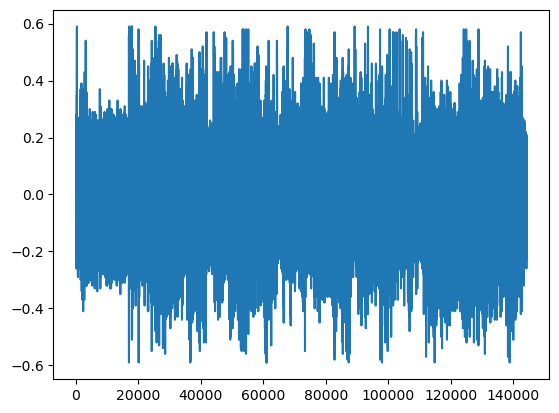

In [4]:
# visually inspect the data
plt.plot(df['delta_T'])

The volumetric flow values are a lot bigger and not the real extrusion, when the value is above a threshold.

In [5]:
# unretractions result in high flow 

max_flow: float = 18 # mm^3/s
df = df[df['volumetric_flow'] < max_flow]

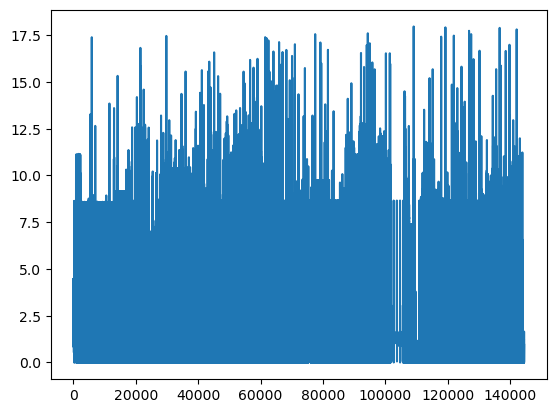

In [6]:
# visually inspect the data
plt.plot(df['volumetric_flow'])


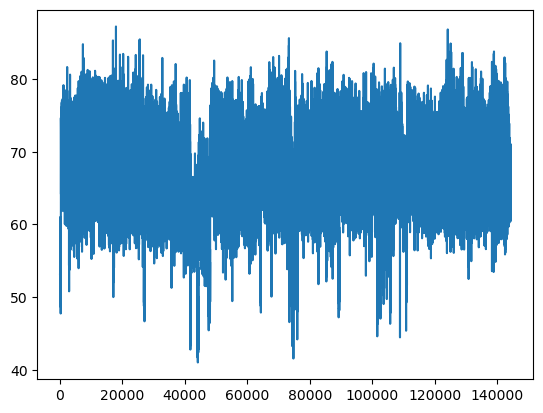

In [7]:
plt.plot(df['extruder_power'])

## Visually show the correlation in between heater cycle time and volumetric flow

In [8]:
#df = df[df['T'] == 215] 
# find where a print ends
print_end_indices = df[df['id'].diff() != 0].index.tolist()

step = 100
power = pd.Series(df['extruder_power'])
mean_avg_power = power.rolling(int(power.size/step)).mean()
x = pd.Series(range(0, df['timestamp'].size))

flow = pd.Series(df['volumetric_flow'])
mean_avg_flow = flow.rolling(int(flow.size/step)).mean()

correlation = df['volumetric_flow'].corr(df['extruder_power'])
correlation_avg = mean_avg_flow.corr(mean_avg_power)
print(f"Correlation coefficient data: {round(correlation, 4)}; Avg: {round(correlation_avg, 4)}")

Correlation coefficient data: 0.1249; Avg: 0.38


# Calculate time differences
df['time_diff'] = df['timestamp'].diff()
print(f"Time {df['time_diff'].mean()}")

# Calculate derivatives
df['flow_derivative'] = mean_avg_flow.diff() / step
df['power_derivative'] = mean_avg_power.diff() / step
# Drop the first row with NaN values resulting from the diff()
df_derivatives = df.dropna(subset=['flow_derivative', 'power_derivative'])
# Calculate correlation coefficient
correlation_derivative = df_derivatives['flow_derivative'].corr(df_derivatives['power_derivative'])
print(f"Correlation coefficient of derivatives: {correlation_derivative}")

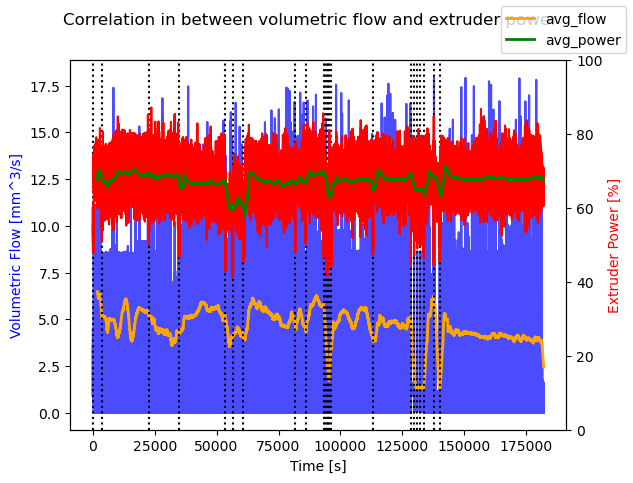

In [9]:
#%matplotlib widget
time = df['timestamp']
#plt.plot(time ,df['volumetric_flow'])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)
ax1.plot(time,df['volumetric_flow'], 'b',alpha=0.7)
ax1.plot(time, mean_avg_flow, 'orange', linewidth=2, label='avg_flow')

ax2.plot(time,df['extruder_power'], color='r')
ax2.plot(time, mean_avg_power, 'g', linewidth=2, label='avg_power')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Volumetric Flow [mm^3/s]', color='b')
ax2.set_ylabel('Extruder Power [%]', color='r')
fig.suptitle('Correlation in between volumetric flow and extruder power')
fig.legend()

for index in print_end_indices:
	ax1.axvline(x=time[index], color='black', linestyle=':')
